# Bus Violence Detection System
# Two-Stage Deep Learning Framework: YOLOv8 + 3D-CNN

---

## 🎯 Project Overview

This notebook implements a **two-stage violence detection system** specifically designed for the **Bus Violence dataset** using state-of-the-art deep learning techniques:

- **Stage 1**: YOLOv8 for efficient person detection and frame filtering
- **Stage 2**: 3D Convolutional Neural Network (C3D) for spatiotemporal violence classification

### Dataset Information
- **Name**: Bus Violence Dataset
- **Total Videos**: 1,400 clips (700 violent, 700 non-violent)
- **Source**: Multiple cameras inside moving buses
- **Frame Rate**: 25 FPS
- **Camera Configurations**:
  - 2 corner cameras: 960×540 px
  - 1 fisheye camera (middle): 1280×960 px
- **Unique Challenges**:
  - Dynamic backgrounds due to bus movement
  - Varying illumination conditions
  - Multiple camera angles and resolutions

### Citation
```
Ciampi, L., et al. (2022). Bus Violence: An Open Benchmark for Video 
Violence Detection on Public Transport. Sensors, 22(21), 8345.
```

### System Architecture
```
Video Input → YOLOv8 Person Detection → Filtered Frames → 3D-CNN → Violence Classification
```

---

## 1. Setup & Environment Configuration

### Install Dependencies & Import Libraries

In [ ]:
# Install required packages
!pip install ultralytics

print("✅ Packages installed successfully!")

In [1]:
# Core Libraries
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,
    TensorBoard, CSVLogger
)

# Ultralytics YOLOv8
#from ultralytics import YOLO

# Scikit-learn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.utils import shuffle

# Utilities
from tqdm.notebook import tqdm
import json
import pickle
from datetime import datetime
import random

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

2025-11-15 09:43:00.800447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763199781.009192      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763199781.071222      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ All libraries imported successfully!
TensorFlow version: 2.18.0
Keras version: 3.8.0


In [2]:
# Configure Dual GPU Strategy for Kaggle T4 GPUs
strategy = tf.distribute.MirroredStrategy()
print(f"🚀 Number of GPUs detected: {strategy.num_replicas_in_sync}")

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to prevent OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU memory growth enabled for {len(gpus)} GPU(s)")
        
        # Print GPU details
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu.name}")
    except RuntimeError as e:
        print(f"❌ Error configuring GPUs: {e}")
else:
    print("⚠️ No GPUs detected. Running on CPU.")

# Set random seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"\n✅ Random seed set to {SEED} for reproducibility")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
🚀 Number of GPUs detected: 2
❌ Error configuring GPUs: Physical devices cannot be modified after being initialized

✅ Random seed set to 42 for reproducibility


I0000 00:00:1763199801.556526      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763199801.557339      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
# Define paths - Kaggle environment
BASE_DIR = Path(r"/kaggle/input")
OUTPUT_DIR = Path(r"/kaggle/working/")
DATASET_DIR = Path(r"/kaggle/input/bus-violence")

# Create output directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "models").mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "visualizations").mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "logs").mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "predictions").mkdir(parents=True, exist_ok=True)

# Verify dataset directory
if DATASET_DIR.exists():
    print(f"✅ Dataset found at: {DATASET_DIR}")
    print(f"\nDataset structure:")
    for item in sorted(DATASET_DIR.iterdir())[:10]:
        print(f"  - {item.name}")
else:
    print(f"❌ Dataset not found at: {DATASET_DIR}")
    print("Please ensure the Bus Violence dataset is properly uploaded to Kaggle.")

print(f"\n📁 Output directory: {OUTPUT_DIR}")

✅ Dataset found at: /kaggle/input/bus-violence

Dataset structure:
  - NoViolence
  - README.pdf
  - Violence
  - test.txt
  - train.txt

📁 Output directory: /kaggle/working


## 2. Dataset Exploration & Analysis

### Load Dataset Split Files (train.txt & test.txt)

In [5]:
def load_split_files(dataset_root, train_txt='train.txt', test_txt='test.txt'):
    """
    Load video paths and labels from train.txt and test.txt files
    
    Args:
        dataset_root: Path to dataset root directory
        train_txt: Name of training split file
        test_txt: Name of test split file
    
    Returns:
        train_videos, train_labels, test_videos, test_labels
    """
    train_videos = []
    train_labels = []
    
    train_file = Path(dataset_root) / train_txt
    test_file = Path(dataset_root) / test_txt
    
    # Load training split
    if train_file.exists():
        with open(train_file, 'r') as f:
            for line in f:
                video_name = line.strip()
                if not video_name:
                    continue
                
                # Determine label from folder structure
                if 'Violence/' in video_name and 'NoViolence' not in video_name:
                    label = 1  # Violent
                    video_path = Path(dataset_root) / video_name
                elif 'NoViolence' in video_name:
                    label = 0  # Non-violent
                    video_path = Path(dataset_root) / video_name
                else:
                    # Try to find the video in Violence or NoViolence folders
                    violence_path = Path(dataset_root) / 'Violence' / video_name
                    no_violence_path = Path(dataset_root) / 'NoViolence' / video_name
                    
                    if violence_path.exists():
                        label = 1
                        video_path = violence_path
                    elif no_violence_path.exists():
                        label = 0
                        video_path = no_violence_path
                    else:
                        print(f"⚠️ Video not found: {video_name}")
                        continue
                
                if video_path.exists():
                    train_videos.append(str(video_path))
                    train_labels.append(label)
    else:
        print(f"❌ Training split file not found: {train_file}")
    
    # Load test split
    test_videos = []
    test_labels = []
    
    if test_file.exists():
        with open(test_file, 'r') as f:
            for line in f:
                video_name = line.strip()
                if not video_name:
                    continue
                
                # Determine label from folder structure
                if 'Violence/' in video_name and 'NoViolence' not in video_name:
                    label = 1  # Violent
                    video_path = Path(dataset_root) / video_name
                elif 'NoViolence' in video_name:
                    label = 0  # Non-violent
                    video_path = Path(dataset_root) / video_name
                else:
                    # Try to find the video in Violence or NoViolence folders
                    violence_path = Path(dataset_root) / 'Violence' / video_name
                    no_violence_path = Path(dataset_root) / 'NoViolence' / video_name
                    
                    if violence_path.exists():
                        label = 1
                        video_path = violence_path
                    elif no_violence_path.exists():
                        label = 0
                        video_path = no_violence_path
                    else:
                        print(f"⚠️ Video not found: {video_name}")
                        continue
                
                if video_path.exists():
                    test_videos.append(str(video_path))
                    test_labels.append(label)
    else:
        print(f"❌ Test split file not found: {test_file}")
    
    return train_videos, train_labels, test_videos, test_labels


# Load dataset splits
train_videos, train_labels, test_videos, test_labels = load_split_files(DATASET_DIR)

print("=" * 60)
print("📊 DATASET STATISTICS")
print("=" * 60)
print(f"\n📁 Training Set:")
print(f"  Total videos: {len(train_videos)}")
print(f"  Violent videos: {sum(train_labels)} ({sum(train_labels)/len(train_labels)*100:.1f}%)")
print(f"  Non-violent videos: {len(train_labels) - sum(train_labels)} ({(len(train_labels) - sum(train_labels))/len(train_labels)*100:.1f}%)")

print(f"\n📁 Test Set:")
print(f"  Total videos: {len(test_videos)}")
print(f"  Violent videos: {sum(test_labels)} ({sum(test_labels)/len(test_labels)*100:.1f}%)")
print(f"  Non-violent videos: {len(test_labels) - sum(test_labels)} ({(len(test_labels) - sum(test_labels))/len(test_labels)*100:.1f}%)")

print(f"\n📊 Total Dataset:")
print(f"  Total videos: {len(train_videos) + len(test_videos)}")
print(f"  Train/Test split: {len(train_videos)}/{len(test_videos)} ({len(train_videos)/(len(train_videos)+len(test_videos))*100:.1f}% / {len(test_videos)/(len(train_videos)+len(test_videos))*100:.1f}%)")
print("=" * 60)

📊 DATASET STATISTICS

📁 Training Set:
  Total videos: 1120
  Violent videos: 560 (50.0%)
  Non-violent videos: 560 (50.0%)

📁 Test Set:
  Total videos: 280
  Violent videos: 140 (50.0%)
  Non-violent videos: 140 (50.0%)

📊 Total Dataset:
  Total videos: 1400
  Train/Test split: 1120/280 (80.0% / 20.0%)


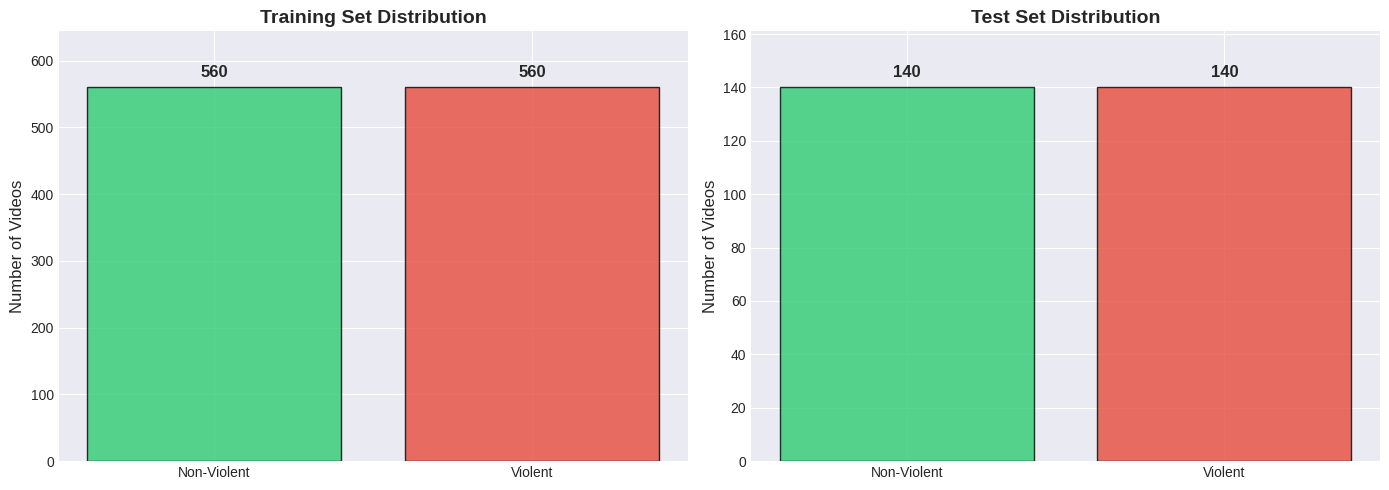

✅ Dataset distribution visualization saved!


In [6]:
# Visualize dataset distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
train_counts = [len(train_labels) - sum(train_labels), sum(train_labels)]
axes[0].bar(['Non-Violent', 'Violent'], train_counts, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Videos', fontsize=12)
axes[0].set_ylim(0, max(train_counts) * 1.15)
for i, v in enumerate(train_counts):
    axes[0].text(i, v + max(train_counts) * 0.02, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Test set distribution
test_counts = [len(test_labels) - sum(test_labels), sum(test_labels)]
axes[1].bar(['Non-Violent', 'Violent'], test_counts, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Videos', fontsize=12)
axes[1].set_ylim(0, max(test_counts) * 1.15)
for i, v in enumerate(test_counts):
    axes[1].text(i, v + max(test_counts) * 0.02, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'visualizations' / 'dataset_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Dataset distribution visualization saved!")

In [6]:
# Sample video analysis - extract basic information
def get_video_info(video_path):
    """Extract video metadata"""
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = frame_count / fps if fps > 0 else 0
    cap.release()
    
    return {
        'fps': fps,
        'frame_count': frame_count,
        'width': width,
        'height': height,
        'duration': duration,
        'resolution': f"{width}x{height}"
    }

# Analyze sample videos
print("🎬 Analyzing sample videos...")
sample_videos = train_videos[:5] + test_videos[:5]
video_info_list = []

for video_path in tqdm(sample_videos, desc="Extracting video info"):
    try:
        info = get_video_info(video_path)
        info['path'] = Path(video_path).name
        video_info_list.append(info)
    except Exception as e:
        print(f"Error processing {video_path}: {e}")

# Create DataFrame
df_video_info = pd.DataFrame(video_info_list)

print("\n📊 Sample Video Information:")
print(df_video_info.to_string(index=False))

print(f"\n📈 Video Statistics:")
print(f"  Average FPS: {df_video_info['fps'].mean():.1f}")
print(f"  Average frame count: {df_video_info['frame_count'].mean():.1f}")
print(f"  Average duration: {df_video_info['duration'].mean():.2f} seconds")
print(f"  Common resolutions: {df_video_info['resolution'].value_counts().to_dict()}")

🎬 Analyzing sample videos...


Extracting video info:   0%|          | 0/10 [00:00<?, ?it/s]


📊 Sample Video Information:
 fps  frame_count  width  height  duration resolution              path
  30           48   1280     960       1.6   1280x960  VIOLENCE_946.mp4
  30           48   1280     960       1.6   1280x960  VIOLENCE_547.mp4
  30           48   1280     960       1.6   1280x960  VIOLENCE_784.mp4
  30           48   1280     960       1.6   1280x960  VIOLENCE_330.mp4
  30           48   1280     960       1.6   1280x960  VIOLENCE_189.mp4
  30           21    352     288       0.7    352x288  VIOLENCE_216.mp4
  30           48    960     540       1.6    960x540 VIOLENCE_1252.mp4
  30           48   1280     960       1.6   1280x960 VIOLENCE_1156.mp4
  30           21    352     288       0.7    352x288  VIOLENCE_104.mp4
  30           48   1280     960       1.6   1280x960  VIOLENCE_276.mp4

📈 Video Statistics:
  Average FPS: 30.0
  Average frame count: 42.6
  Average duration: 1.42 seconds
  Common resolutions: {'1280x960': 7, '352x288': 2, '960x540': 1}


## 3. Stage 1: YOLOv8 Person Detection & Frame Filtering

### Load YOLOv8 Model for Person Detection

In [10]:
# YOLOv8 Configuration
YOLO_MODEL_SIZE = 'yolov8n.pt'  # Options: yolov8n.pt (nano), yolov8s.pt (small)
YOLO_CONF_THRESHOLD = 0.5  # Confidence threshold for person detection
PERSON_CLASS_ID = 0  # COCO dataset person class ID
IOU_THRESHOLD = 0.45  # Intersection over Union threshold

# Load YOLOv8 model
print(f"🚀 Loading YOLOv8 model: {YOLO_MODEL_SIZE}")
yolo_model = YOLO(YOLO_MODEL_SIZE)

print(f"✅ YOLOv8 model loaded successfully!")
print(f"📊 Model configuration:")
print(f"  - Model: {YOLO_MODEL_SIZE}")
print(f"  - Confidence threshold: {YOLO_CONF_THRESHOLD}")
print(f"  - Person class ID: {PERSON_CLASS_ID}")
print(f"  - IOU threshold: {IOU_THRESHOLD}")

🚀 Loading YOLOv8 model: yolov8n.pt
✅ YOLOv8 model loaded successfully!
📊 Model configuration:
  - Model: yolov8n.pt
  - Confidence threshold: 0.5
  - Person class ID: 0
  - IOU threshold: 0.45


In [11]:
def detect_persons_in_frame(frame, yolo_model, conf_threshold=0.5, person_class_id=0):
    """
    Detect persons in a frame using YOLOv8
    
    Args:
        frame: Input frame (numpy array)
        yolo_model: YOLOv8 model instance
        conf_threshold: Confidence threshold for detection
        person_class_id: Class ID for person (0 in COCO dataset)
    
    Returns:
        has_person: Boolean indicating if at least one person was detected
        detections: List of detection boxes [x1, y1, x2, y2, confidence]
    """
    # Run YOLOv8 inference
    results = yolo_model(frame, classes=[person_class_id], conf=conf_threshold, verbose=False)
    
    detections = []
    has_person = False
    
    if len(results) > 0 and results[0].boxes is not None:
        boxes = results[0].boxes
        if len(boxes) > 0:
            has_person = True
            # Extract bounding boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                detections.append([x1, y1, x2, y2, conf])
    
    return has_person, detections


def filter_frames_with_yolo(video_path, yolo_model, conf_threshold=0.5, max_frames=None):
    """
    Filter video frames that contain at least one person
    
    Args:
        video_path: Path to video file
        yolo_model: YOLOv8 model instance
        conf_threshold: Confidence threshold
        max_frames: Maximum number of frames to process (None for all)
    
    Returns:
        filtered_frames: List of frames containing persons
        frame_indices: List of original frame indices
        detection_stats: Dictionary with detection statistics
    """
    cap = cv2.VideoCapture(video_path)
    filtered_frames = []
    frame_indices = []
    total_frames = 0
    frames_with_person = 0
    
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        total_frames += 1
        
        # Check if max_frames limit reached
        if max_frames is not None and total_frames > max_frames:
            break
        
        # Detect persons in frame
        has_person, detections = detect_persons_in_frame(
            frame, yolo_model, conf_threshold=conf_threshold
        )
        
        if has_person:
            frames_with_person += 1
            filtered_frames.append(frame)
            frame_indices.append(frame_idx)
        
        frame_idx += 1
    
    cap.release()
    
    detection_stats = {
        'total_frames': total_frames,
        'frames_with_person': frames_with_person,
        'detection_rate': frames_with_person / total_frames if total_frames > 0 else 0
    }
    
    return filtered_frames, frame_indices, detection_stats


# Test person detection on a sample video
print("🎬 Testing YOLOv8 person detection on sample video...")
sample_video = train_videos[0]
print(f"Sample video: {Path(sample_video).name}")

# Filter frames
filtered_frames, frame_indices, stats = filter_frames_with_yolo(
    sample_video, 
    yolo_model, 
    conf_threshold=YOLO_CONF_THRESHOLD,
    max_frames=50  # Test on first 50 frames
)

print(f"\n📊 Detection Statistics:")
print(f"  Total frames processed: {stats['total_frames']}")
print(f"  Frames with person(s): {stats['frames_with_person']}")
print(f"  Detection rate: {stats['detection_rate']*100:.1f}%")
print(f"  Filtered frames count: {len(filtered_frames)}")

🎬 Testing YOLOv8 person detection on sample video...
Sample video: VIOLENCE_946.mp4

📊 Detection Statistics:
  Total frames processed: 48
  Frames with person(s): 42
  Detection rate: 87.5%
  Filtered frames count: 42


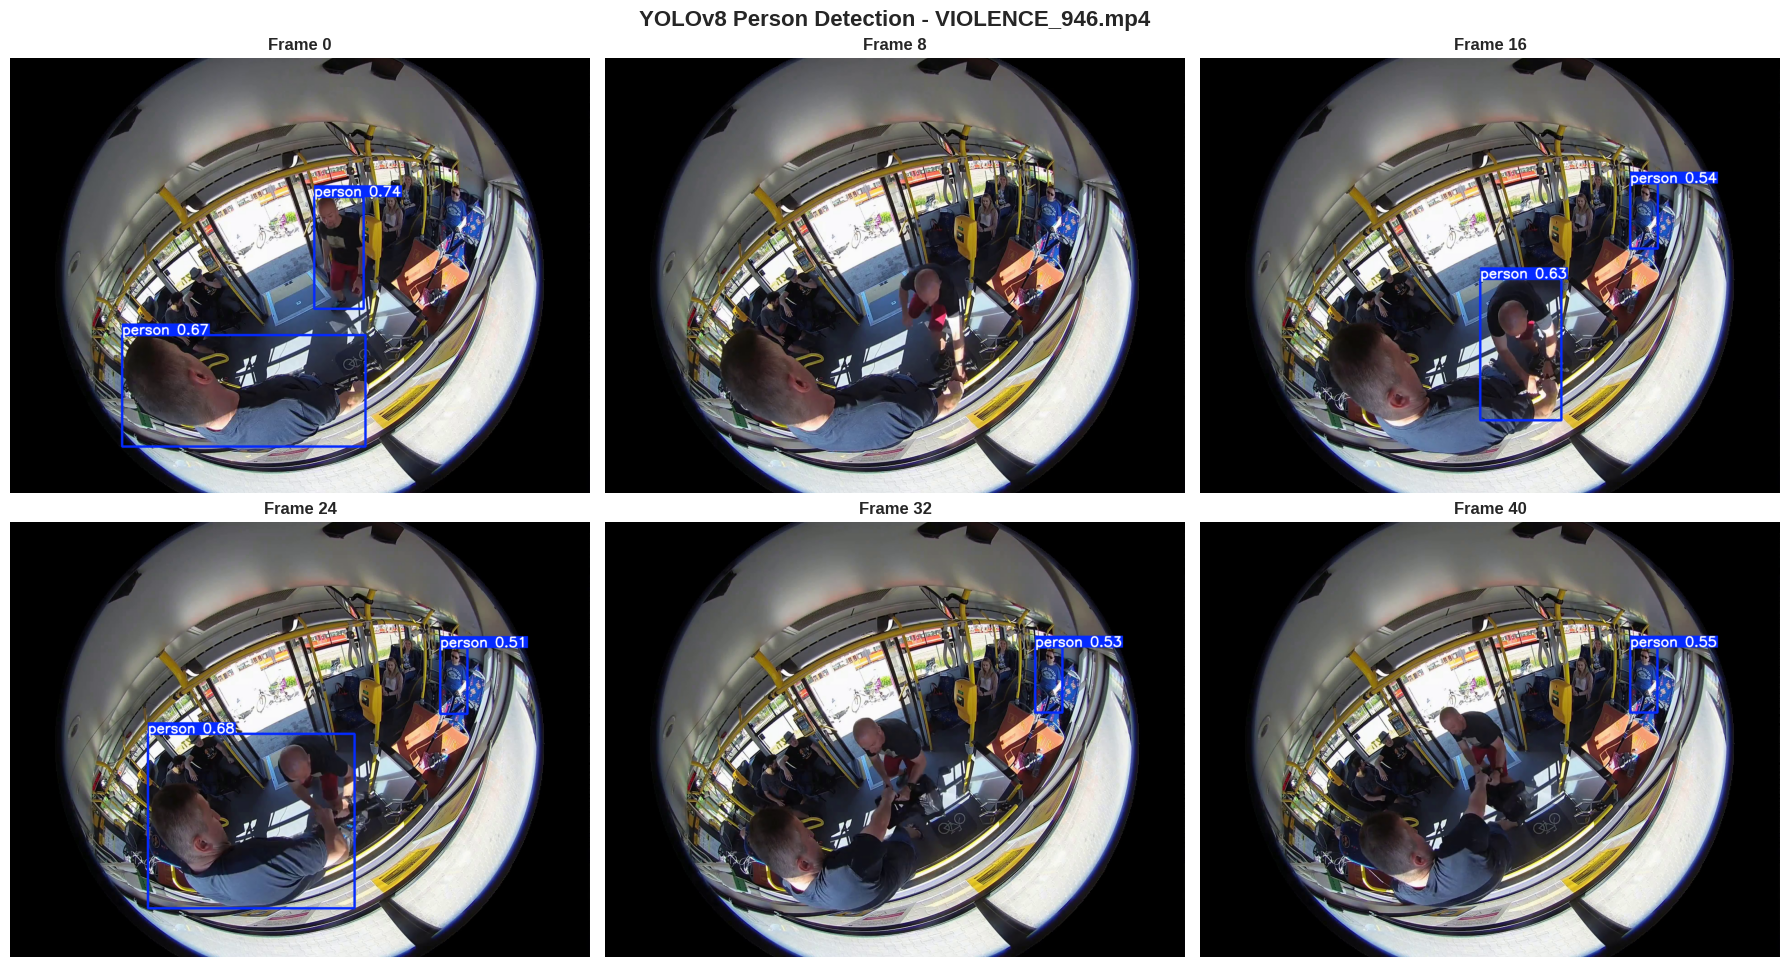

✅ YOLOv8 detection visualization saved!


In [12]:
# Visualize YOLOv8 detections on sample frames
def visualize_yolo_detections(video_path, yolo_model, num_frames=6, conf_threshold=0.5):
    """Visualize YOLOv8 person detections on sample frames"""
    cap = cv2.VideoCapture(video_path)
    frames_to_show = []
    frame_count = 0
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = max(1, total_frames // num_frames)
    
    while len(frames_to_show) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % frame_step == 0:
            # Run YOLOv8 detection
            results = yolo_model(frame, classes=[PERSON_CLASS_ID], conf=conf_threshold, verbose=False)
            
            # Annotate frame
            if len(results) > 0:
                annotated_frame = results[0].plot()
                frames_to_show.append(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
            else:
                frames_to_show.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        frame_count += 1
    
    cap.release()
    
    # Plot frames
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, frame in enumerate(frames_to_show):
        if i < len(axes):
            axes[i].imshow(frame)
            axes[i].axis('off')
            axes[i].set_title(f'Frame {i*frame_step}', fontsize=12, fontweight='bold')
    
    plt.suptitle(f'YOLOv8 Person Detection - {Path(video_path).name}', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'visualizations' / 'yolo_detections_sample.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ YOLOv8 detection visualization saved!")

# Visualize detections
visualize_yolo_detections(sample_video, yolo_model, num_frames=6, conf_threshold=YOLO_CONF_THRESHOLD)

## 4. Data Preprocessing & Video Loading

### Define Preprocessing Pipeline for 3D-CNN

In [7]:
# Preprocessing Configuration
SEQUENCE_LENGTH = 30  # Number of frames per sequence
IMG_HEIGHT =112  # Target frame height
IMG_WIDTH = 112  # Target frame width
IMG_CHANNELS = 3  # RGB
BATCH_SIZE = 16 # Batch size for training (adjust based on GPU memory)
EPOCHS = 50  # Number of training epochs
LEARNING_RATE = 0.001  # Initial learning rate

# Normalization method
NORMALIZATION = 'zero_one'  # Options: 'zero_one', 'neg_one_one', 'imagenet'

# Data augmentation settings
USE_AUGMENTATION = False
AUGMENTATION_PROB = 0.5

print("=" * 60)
print("⚙️ PREPROCESSING CONFIGURATION")
print("=" * 60)
print(f"Sequence length: {SEQUENCE_LENGTH} frames")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Normalization: {NORMALIZATION}")
print(f"Data augmentation: {USE_AUGMENTATION}")
print(f"Augmentation probability: {AUGMENTATION_PROB}")
print("=" * 60)

⚙️ PREPROCESSING CONFIGURATION
Sequence length: 30 frames
Image size: 112x112x3
Batch size: 16
Normalization: zero_one
Data augmentation: False
Augmentation probability: 0.5


In [8]:
def normalize_frames(frames, method='zero_one'):
    """
    Normalize frame pixel values
    
    Args:
        frames: numpy array of frames
        method: Normalization method ('zero_one', 'neg_one_one', 'imagenet')
    
    Returns:
        Normalized frames
    """
    frames = frames.astype(np.float32)
    
    if method == 'zero_one':
        # Normalize to [0, 1]
        frames = frames / 255.0
    elif method == 'neg_one_one':
        # Normalize to [-1, 1]
        frames = (frames / 127.5) - 1.0
    elif method == 'imagenet':
        # ImageNet normalization
        mean = np.array([123.675, 116.28, 103.53])
        std = np.array([58.395, 57.12, 57.375])
        frames = (frames - mean) / std
    else:
        raise ValueError(f"Unknown normalization method: {method}")
    
    return frames


def load_video_sequence(video_path, sequence_length=16, img_size=(112, 112), 
                       use_yolo_filter=False, yolo_model=None, conf_threshold=0.5,
                       normalization='zero_one'):
    """
    Load video and extract frame sequence
    
    Args:
        video_path: Path to video file
        sequence_length: Number of frames to extract
        img_size: Target frame size (height, width)
        use_yolo_filter: Whether to use YOLOv8 filtering
        yolo_model: YOLOv8 model instance
        conf_threshold: Confidence threshold for YOLOv8
        normalization: Normalization method
    
    Returns:
        Sequence of frames as numpy array (sequence_length, height, width, channels)
    """
    cap = cv2.VideoCapture(video_path)
    
    if use_yolo_filter and yolo_model is not None:
        # Filter frames with person detection
        filtered_frames, _, _ = filter_frames_with_yolo(
            video_path, yolo_model, conf_threshold=conf_threshold
        )
        frames = filtered_frames
    else:
        # Load all frames
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        cap.release()
    
    # If not enough frames, return None
    if len(frames) < sequence_length:
        # Pad with last frame if needed
        if len(frames) > 0:
            last_frame = frames[-1]
            while len(frames) < sequence_length:
                frames.append(last_frame.copy())
        else:
            return None
    
    # Sample frames uniformly
    if len(frames) > sequence_length:
        indices = np.linspace(0, len(frames) - 1, sequence_length, dtype=int)
        frames = [frames[i] for i in indices]
    
    # Resize and preprocess frames
    processed_frames = []
    for frame in frames[:sequence_length]:
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Resize
        frame_resized = cv2.resize(frame_rgb, img_size, interpolation=cv2.INTER_AREA)
        processed_frames.append(frame_resized)
    
    # Convert to numpy array
    sequence = np.array(processed_frames)
    
    # Normalize
    sequence = normalize_frames(sequence, method=normalization)
    
    return sequence


# Test video loading
print("🎬 Testing video loading pipeline...")
test_video = train_videos[0]
test_sequence = load_video_sequence(
    test_video,
    sequence_length=SEQUENCE_LENGTH,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    use_yolo_filter=False,  # Disable for faster testing
    normalization=NORMALIZATION
)

if test_sequence is not None:
    print(f"✅ Successfully loaded video sequence")
    print(f"   Shape: {test_sequence.shape}")
    print(f"   Data type: {test_sequence.dtype}")
    print(f"   Value range: [{test_sequence.min():.3f}, {test_sequence.max():.3f}]")
else:
    print("❌ Failed to load video sequence")

🎬 Testing video loading pipeline...
✅ Successfully loaded video sequence
   Shape: (30, 112, 112, 3)
   Data type: float32
   Value range: [0.000, 0.996]


## 5. Data Generator for Efficient Loading

### Custom Keras Sequence Generator

In [9]:
class BusViolenceDataGenerator(keras.utils.Sequence):
    """
    Custom Keras Sequence Generator for Bus Violence Dataset
    Efficient data loading with on-the-fly preprocessing
    """
    
    def __init__(self, video_paths, labels, batch_size=8, sequence_length=48,
                 img_size=(224, 224), use_yolo_filter=False, yolo_model=None,
                 conf_threshold=0.5, augment=False, shuffle=True, normalization='neg_one_one'):
        """
        Args:
            video_paths: List of video file paths
            labels: List of labels (0=non-violent, 1=violent)
            batch_size: Number of samples per batch
            sequence_length: Number of frames per sequence
            img_size: Target frame size (H, W)
            use_yolo_filter: Whether to filter frames using YOLOv8
            yolo_model: YOLOv8 model instance
            conf_threshold: YOLOv8 confidence threshold
            augment: Apply data augmentation
            shuffle: Shuffle data after each epoch
            normalization: Normalization method
        """
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.img_size = img_size
        self.use_yolo_filter = use_yolo_filter
        self.yolo_model = yolo_model
        self.conf_threshold = conf_threshold
        self.augment = augment
        self.shuffle = shuffle
        self.normalization = normalization
        self.indexes = np.arange(len(self.video_paths))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        """Returns number of batches per epoch"""
        return int(np.ceil(len(self.video_paths) / self.batch_size))
    
    def __getitem__(self, index):
        """
        Returns one batch of data
        Returns: (batch_sequences, batch_labels)
                 batch_sequences shape: (batch_size, 16, 112, 112, 3)
                 batch_labels shape: (batch_size, 2) one-hot encoded
        """
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Generate data
        X, y = self.__data_generation(batch_indexes)
        
        return X, y
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_indexes):
        """
        Generates data containing batch_size samples
        """
        # Initialization
        X = np.empty((len(batch_indexes), self.sequence_length, 
                     self.img_size[0], self.img_size[1], 3), dtype=np.float32)
        y = np.empty((len(batch_indexes), 2), dtype=np.float32)
        
        # Generate data
        for i, idx in enumerate(batch_indexes):
            # Load video sequence
            video_path = self.video_paths[idx]
            sequence = load_video_sequence(
                video_path,
                sequence_length=self.sequence_length,
                img_size=self.img_size,
                use_yolo_filter=self.use_yolo_filter,
                yolo_model=self.yolo_model,
                conf_threshold=self.conf_threshold,
                normalization=self.normalization
            )
            
            # Handle failed loading
            if sequence is None:
                # Create zero sequence
                sequence = np.zeros((self.sequence_length, self.img_size[0], 
                                   self.img_size[1], 3), dtype=np.float32)
            
            # Apply augmentation if enabled
            if self.augment:
                sequence = self.augment_sequence(sequence)
            
            X[i,] = sequence
            
            # One-hot encode label
            label = self.labels[idx]
            y[i,] = keras.utils.to_categorical(label, num_classes=2)
        
        return X, y
    
    def augment_sequence(self, sequence):
        """
        Apply data augmentation using TensorFlow operations
        """
        # Convert to tensor
        sequence_tensor = tf.constant(sequence)
        
        # Random horizontal flip
        if np.random.random() > 0.5:
            sequence_tensor = tf.image.flip_left_right(sequence_tensor)
        
        # Random brightness adjustment
        if np.random.random() > 0.5:
            sequence_tensor = tf.image.adjust_brightness(sequence_tensor, delta=0.1)
        
        # Random contrast adjustment
        if np.random.random() > 0.5:
            sequence_tensor = tf.image.adjust_contrast(sequence_tensor, contrast_factor=1.2)
        
        # Clip values to valid range
        if self.normalization == 'zero_one':
            sequence_tensor = tf.clip_by_value(sequence_tensor, 0.0, 1.0)
        elif self.normalization == 'neg_one_one':
            sequence_tensor = tf.clip_by_value(sequence_tensor, -1.0, 1.0)
        
        return sequence_tensor.numpy()


print("✅ BusViolenceDataGenerator class defined successfully!")

✅ BusViolenceDataGenerator class defined successfully!


In [10]:
# ⚠️ IMPORTANT: Split training data into train and validation sets
# This prevents data leakage - test set is kept completely separate!

from sklearn.model_selection import train_test_split

print("🔄 Creating train/validation/test split...")
print("\n⚠️  CRITICAL: Preventing data leakage by proper data splitting")
print("   - Training set will be split into train (80%) and validation (20%)")
print("   - Test set is kept completely separate for final evaluation only\n")

# Split training data into train and validation (80/20 split)
train_videos_split, val_videos_split, train_labels_split, val_labels_split = train_test_split(
    train_videos,
    train_labels,
    test_size=0.2,
    stratify=train_labels,  # Maintain class balance
    random_state=SEED
)

print("="*70)
print("📊 DATA SPLIT SUMMARY")
print("="*70)
print(f"\n🔹 Training Set:")
print(f"   Total videos: {len(train_videos_split)}")
print(f"   Violent: {sum(train_labels_split)} ({sum(train_labels_split)/len(train_labels_split)*100:.1f}%)")
print(f"   Non-violent: {len(train_labels_split) - sum(train_labels_split)} ({(len(train_labels_split) - sum(train_labels_split))/len(train_labels_split)*100:.1f}%)")

print(f"\n🔹 Validation Set (from training data):")
print(f"   Total videos: {len(val_videos_split)}")
print(f"   Violent: {sum(val_labels_split)} ({sum(val_labels_split)/len(val_labels_split)*100:.1f}%)")
print(f"   Non-violent: {len(val_labels_split) - sum(val_labels_split)} ({(len(val_labels_split) - sum(val_labels_split))/len(val_labels_split)*100:.1f}%)")

print(f"\n🔹 Test Set (unseen during training):")
print(f"   Total videos: {len(test_videos)}")
print(f"   Violent: {sum(test_labels)} ({sum(test_labels)/len(test_labels)*100:.1f}%)")
print(f"   Non-violent: {len(test_labels) - sum(test_labels)} ({(len(test_labels) - sum(test_labels))/len(test_labels)*100:.1f}%)")

print(f"\n📈 Split Ratio:")
total_samples = len(train_videos_split) + len(val_videos_split) + len(test_videos)
print(f"   Train: {len(train_videos_split)/total_samples*100:.1f}%")
print(f"   Validation: {len(val_videos_split)/total_samples*100:.1f}%")
print(f"   Test: {len(test_videos)/total_samples*100:.1f}%")
print("="*70)

# Create data generators
print("\n🔄 Creating data generators...\n")

# Training generator (with augmentation)
train_generator = BusViolenceDataGenerator(
    video_paths=train_videos_split,
    labels=train_labels_split,
    batch_size=BATCH_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    #use_yolo_filter=False,  # Set to True to enable YOLOv8 filtering (slower but better quality)
    #yolo_model=yolo_model,
    #conf_threshold=YOLO_CONF_THRESHOLD,
    augment=USE_AUGMENTATION,
    shuffle=True,
    normalization=NORMALIZATION
)

# Validation generator (without augmentation, no shuffle)
val_generator = BusViolenceDataGenerator(
    video_paths=val_videos_split,
    labels=val_labels_split,
    batch_size=BATCH_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    #use_yolo_filter=False,
    #yolo_model=yolo_model,
    #conf_threshold=YOLO_CONF_THRESHOLD,
    augment=False,
    shuffle=False,
    normalization=NORMALIZATION
)

# Test generator (without augmentation, no shuffle) - ONLY for final evaluation
test_generator = BusViolenceDataGenerator(
    video_paths=test_videos,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    #use_yolo_filter=False,
    #yolo_model=yolo_model,
    #conf_threshold=YOLO_CONF_THRESHOLD,
    augment=False,
    shuffle=False,
    normalization=NORMALIZATION
)

print(f"✅ Data generators created successfully!")
print(f"\n   Training samples: {len(train_videos_split)}")
print(f"   Training batches: {len(train_generator)}")
print(f"\n   Validation samples: {len(val_videos_split)}")
print(f"   Validation batches: {len(val_generator)}")
print(f"\n   Test samples: {len(test_videos)}")
print(f"   Test batches: {len(test_generator)} (for final evaluation only)")

🔄 Creating train/validation/test split...

⚠️  CRITICAL: Preventing data leakage by proper data splitting
   - Training set will be split into train (80%) and validation (20%)
   - Test set is kept completely separate for final evaluation only

📊 DATA SPLIT SUMMARY

🔹 Training Set:
   Total videos: 896
   Violent: 448 (50.0%)
   Non-violent: 448 (50.0%)

🔹 Validation Set (from training data):
   Total videos: 224
   Violent: 112 (50.0%)
   Non-violent: 112 (50.0%)

🔹 Test Set (unseen during training):
   Total videos: 280
   Violent: 140 (50.0%)
   Non-violent: 140 (50.0%)

📈 Split Ratio:
   Train: 64.0%
   Validation: 16.0%
   Test: 20.0%

🔄 Creating data generators...

✅ Data generators created successfully!

   Training samples: 896
   Training batches: 56

   Validation samples: 224
   Validation batches: 14

   Test samples: 280
   Test batches: 18 (for final evaluation only)


🧪 Testing data generator output...

📊 Batch Information:
   X_batch shape: (16, 30, 112, 112, 3)
   y_batch shape: (16, 2)
   X_batch dtype: float32
   y_batch dtype: float32
   X_batch value range: [0.000, 1.000]
   Sample labels: [[0. 1.]
 [0. 1.]
 [1. 0.]]


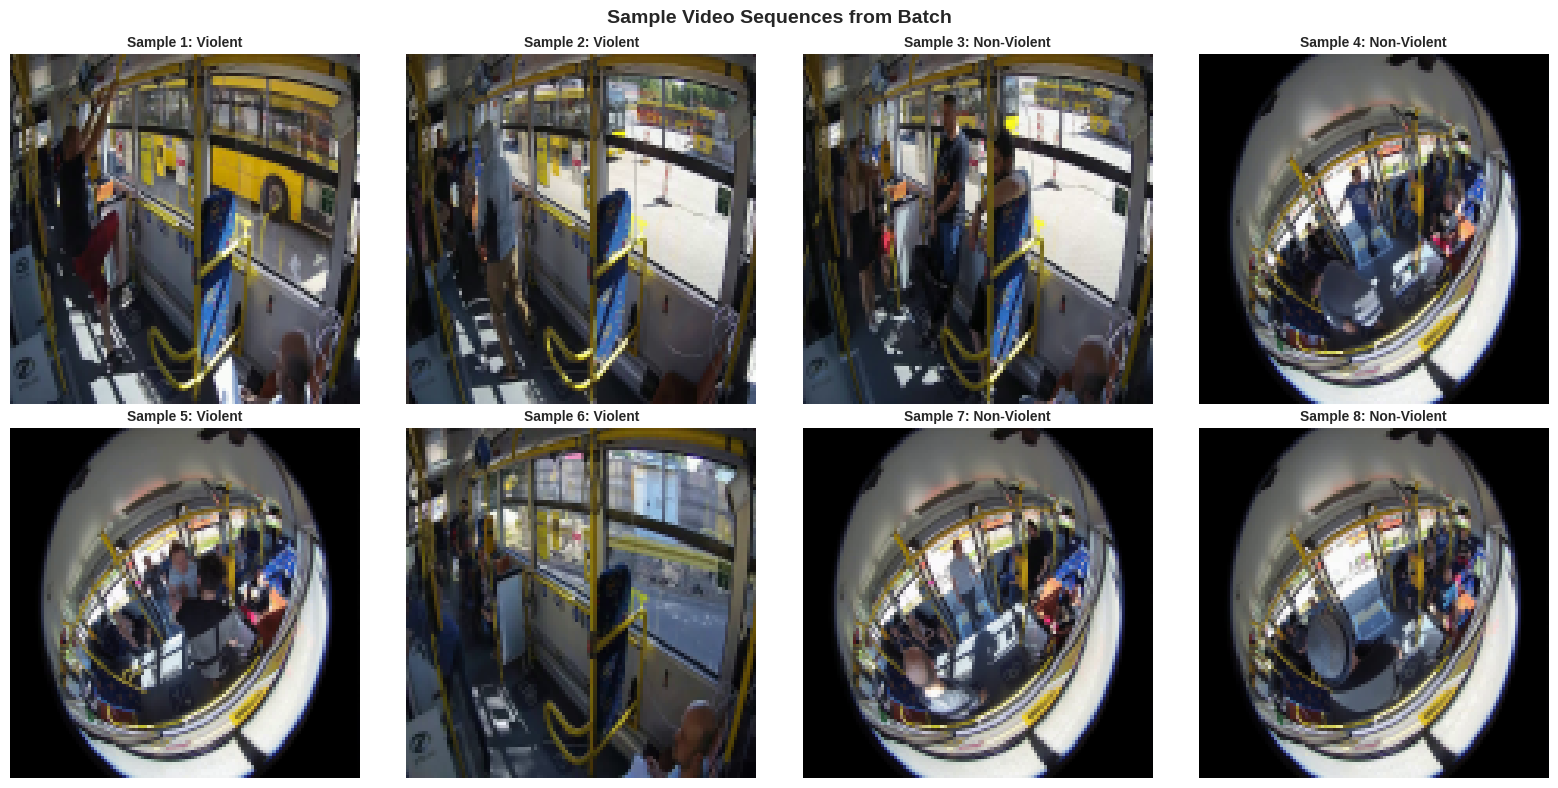

✅ Data generator test completed successfully!


In [11]:
# Test data generator output
print("🧪 Testing data generator output...")
X_batch, y_batch = train_generator[0]

print(f"\n📊 Batch Information:")
print(f"   X_batch shape: {X_batch.shape}")
print(f"   y_batch shape: {y_batch.shape}")
print(f"   X_batch dtype: {X_batch.dtype}")
print(f"   y_batch dtype: {y_batch.dtype}")
print(f"   X_batch value range: [{X_batch.min():.3f}, {X_batch.max():.3f}]")
print(f"   Sample labels: {y_batch[:3]}")

# Visualize sample sequences
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    if i < X_batch.shape[0]:
        # Take middle frame from sequence
        frame = X_batch[i, SEQUENCE_LENGTH//2]
        
        # Denormalize for visualization
        if NORMALIZATION == 'zero_one':
            frame_vis = (frame * 255).astype(np.uint8)
        elif NORMALIZATION == 'neg_one_one':
            frame_vis = ((frame + 1) * 127.5).astype(np.uint8)
        else:
            frame_vis = frame.astype(np.uint8)
        
        axes[i].imshow(frame_vis)
        label_text = "Violent" if np.argmax(y_batch[i]) == 1 else "Non-Violent"
        axes[i].set_title(f'Sample {i+1}: {label_text}', fontsize=10, fontweight='bold')
        axes[i].axis('off')

plt.suptitle('Sample Video Sequences from Batch', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'visualizations' / 'sample_batch_sequences.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Data generator test completed successfully!")

## 6. Stage 2: 3D-CNN Model Architecture (C3D)

### Build C3D-Inspired Network for Violence Detection

In [12]:
def build_c3d_model(input_shape=(16, 112, 112, 3), num_classes=2):
    """
    Build C3D-inspired 3D CNN for violence detection
    
    Architecture based on "Learning Spatiotemporal Features with 3D CNNs"
    Adapted for Bus Violence dataset with dual-GPU training support
    
    Args:
        input_shape: (depth, height, width, channels) = (16, 112, 112, 3)
        num_classes: Number of output classes (2 for binary classification)
    
    Returns:
        keras.Model
    """
    
    model = models.Sequential([
        # Conv Block 1
        layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', 
                     padding='same', name='conv1',
                     input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='pool1'),
        
        # Conv Block 2
        layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', 
                     padding='same', name='conv2'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name='pool2'),
        
        # Conv Block 3
        layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu', 
                     padding='same', name='conv3a'),
        layers.BatchNormalization(),
        layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu', 
                     padding='same', name='conv3b'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name='pool3'),
        
        # Conv Block 4
        layers.Conv3D(512, kernel_size=(3, 3, 3), activation='relu', 
                     padding='same', name='conv4a'),
        layers.BatchNormalization(),
        layers.Conv3D(512, kernel_size=(3, 3, 3), activation='relu', 
                     padding='same', name='conv4b'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name='pool4'),
        
        # Conv Block 5
        layers.Conv3D(512, kernel_size=(3, 3, 3), activation='relu', 
                     padding='same', name='conv5a'),
        layers.BatchNormalization(),
        layers.Conv3D(512, kernel_size=(3, 3, 3), activation='relu', 
                     padding='same', name='conv5b'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name='pool5'),
        
        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(4096, activation='relu', name='fc6',
                    kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu', name='fc7',
                    kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', name='fc8')
    ])
    
    return model


# Build model within distributed strategy for multi-GPU training
print("🏗️ Building C3D model with MirroredStrategy for dual-GPU training...")

with strategy.scope():
    model = build_c3d_model(
        input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
        num_classes=2
    )
    
    print(f"✅ Model built successfully within distributed strategy!")

# Model summary
print("\n" + "="*80)
print("📊 MODEL ARCHITECTURE SUMMARY")
print("="*80)
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\n💾 Total parameters: {total_params:,}")
print(f"   Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
print(f"   Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")

🏗️ Building C3D model with MirroredStrategy for dual-GPU training...
✅ Model built successfully within distributed strategy!

📊 MODEL ARCHITECTURE SUMMARY


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv3D)                  │ (None, 30, 112, 112,   │         5,248 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 112, 112,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling3D)            │ (None, 30, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv3D)                  │ (None, 30, 56, 56,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 56, 56,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling3D)            │ (None, 15, 28, 28,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3a (Conv3D)                 │ (None, 15, 28, 28,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 28, 28,     │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3b (Conv3D)                 │ (None, 15, 28, 28,     │     1,769,728 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 28, 28,     │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling3D)            │ (None, 7, 14, 14, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4a (Conv3D)                 │ (None, 7, 14, 14, 512) │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 14, 14, 512) │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4b (Conv3D)                 │ (None, 7, 14, 14, 512) │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 14, 14, 512) │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling3D)            │ (None, 3, 7, 7, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5a (Conv3D)                 │ (None, 3, 7, 7, 512)   │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3, 7, 7, 512)   │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5b (Conv3D)                 │ (None, 3, 7, 7, 512)   │     7,078,40

 Total params: 63,334,914 (241.60 MB)

 Trainable params: 63,329,410 (241.58 MB)

 Non-trainable params: 5,504 (21.50 KB)


💾 Total parameters: 63,334,914
   Trainable parameters: 63,329,410
   Non-trainable parameters: 5,504


## 7. Model Compilation & Training Configuration

### Define Optimizer, Loss, Metrics, and Callbacks

In [13]:
# Compile model within distributed strategy
with strategy.scope():
    # Optimizer
    optimizer = keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        decay=1e-5

    )
    
    # Loss function
    loss_fn = keras.losses.CategoricalCrossentropy()
    
    # Metrics
    metrics = [
        keras.metrics.CategoricalAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=metrics
    )
    
    print("✅ Model compiled successfully within distributed strategy!")

# Define callbacks
callbacks = [
    # Model Checkpoint - Save best model
    ModelCheckpoint(
        filepath=str(OUTPUT_DIR / 'models' / 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    
    # Early Stopping
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Learning Rate Scheduler
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # TensorBoard
    TensorBoard(
        log_dir=str(OUTPUT_DIR / 'logs'),
        histogram_freq=1,
        write_graph=True,
        write_images=False
    ),
    
    # CSV Logger
    CSVLogger(
        filename=str(OUTPUT_DIR / 'training_log.csv'),
        separator=',',
        append=False
    )
]

print("\n📋 Training Configuration:")
print(f"  Optimizer: Adam")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Loss function: Categorical Crossentropy")
print(f"  Metrics: Accuracy, Precision, Recall, AUC")
print(f"  Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  GPU strategy: MirroredStrategy ({strategy.num_replicas_in_sync} GPUs)")

✅ Model compiled successfully within distributed strategy!

📋 Training Configuration:
  Optimizer: Adam
  Learning rate: 0.001
  Loss function: Categorical Crossentropy
  Metrics: Accuracy, Precision, Recall, AUC
  Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
  Epochs: 50
  Batch size: 16
  GPU strategy: MirroredStrategy (2 GPUs)


In [14]:
# Verify data generators are working correctly
print("🔍 Verifying data generators...")
print("\n1️⃣ Checking batch output:")
X_test, y_test = train_generator[0]
print(f"   Batch shape: {X_test.shape}")
print(f"   Labels shape: {y_test.shape}")
print(f"   Unique labels in batch: {np.unique(np.argmax(y_test, axis=1))}")
print(f"   Label distribution: Non-Violent={np.sum(np.argmax(y_test, axis=1)==0)}, Violent={np.sum(np.argmax(y_test, axis=1)==1)}")

print("\n2️⃣ Checking data normalization:")
print(f"   Min value: {X_test.min():.4f}")
print(f"   Max value: {X_test.max():.4f}")
print(f"   Mean value: {X_test.mean():.4f}")
print(f"   Std value: {X_test.std():.4f}")

print("\n3️⃣ Checking for NaN or Inf values:")
print(f"   NaN in data: {np.isnan(X_test).any()}")
print(f"   Inf in data: {np.isinf(X_test).any()}")

print("\n✅ Data generators verified!")
print("\n💡 Training Tips:")
print("   - Watch for stable decreasing loss")
print("   - Training accuracy should gradually increase from ~50%")
print("   - Validation AUC should be > 0.5 (better than random)")
print("   - If loss doesn't decrease after 5 epochs, stop and check data")

🔍 Verifying data generators...

1️⃣ Checking batch output:
   Batch shape: (16, 30, 112, 112, 3)
   Labels shape: (16, 2)
   Unique labels in batch: [0 1]
   Label distribution: Non-Violent=5, Violent=11

2️⃣ Checking data normalization:
   Min value: 0.0000
   Max value: 1.0000
   Mean value: 0.3222
   Std value: 0.2613

3️⃣ Checking for NaN or Inf values:
   NaN in data: False
   Inf in data: False

✅ Data generators verified!

💡 Training Tips:
   - Watch for stable decreasing loss
   - Training accuracy should gradually increase from ~50%
   - Validation AUC should be > 0.5 (better than random)
   - If loss doesn't decrease after 5 epochs, stop and check data


In [15]:
# Train the model
print("="*80)
print("🚀 STARTING MODEL TRAINING")
print("="*80)
print(f"Training on {strategy.num_replicas_in_sync} GPU(s)")
print(f"\n⚠️  Data Split (NO DATA LEAKAGE):")
print(f"   Training samples: {len(train_videos_split)}")
print(f"   Validation samples: {len(val_videos_split)} (from training data)")
print(f"   Test samples: {len(test_videos)} (completely unseen - for final eval only)")
print(f"\nTraining batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(val_generator)}")
print("="*80)

# Start training
history = model.fit(
    train_generator,
    validation_data=val_generator, 
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*80)
print("✅ TRAINING COMPLETED!")
print("="*80)

🚀 STARTING MODEL TRAINING
Training on 2 GPU(s)

⚠️  Data Split (NO DATA LEAKAGE):
   Training samples: 896
   Validation samples: 224 (from training data)
   Test samples: 280 (completely unseen - for final eval only)

Training batches per epoch: 56
Validation batches per epoch: 14
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/50
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 38 all_reduces, num_devices = 2, group_size = 2, implementa

I0000 00:00:1763199922.666195     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763199922.666217     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4502 - auc: 0.4387 - loss: 36.5939 - precision: 0.4502 - recall: 0.4502INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = Commu

56/56 ━━━━━━━━━━━━━━━━━━━━ 287s 5s/step - accuracy: 0.4503 - auc: 0.4387 - loss: 36.6012 - precision: 0.4503 - recall: 0.4503 - val_accuracy: 0.4362 - val_auc: 0.4065 - val_loss: 5.3212 - val_precision: 0.4362 - val_recall: 0.4362 - learning_rate: 0.0010
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3657 - auc: 0.3412 - loss: 2.1214 - precision: 0.3657 - recall: 0.3657INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).



Epoch 2: val_accuracy did not improve from 0.43621
56/56 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.3658 - auc: 0.3412 - loss: 2.1214 - precision: 0.3658 - recall: 0.3658 - val_accuracy: 0.3772 - val_auc: 0.3822 - val_loss: 1.9127 - val_precision: 0.3772 - val_recall: 0.3772 - learning_rate: 0.0010
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4426 - auc: 0.4512 - loss: 1.5796 - precision: 0.4426 - recall: 0.4426INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).



Epoch 3: val_accuracy improved from 0.43621 to 0.55652, saving model to /kaggle/working/models/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.4426 - auc: 0.4512 - loss: 1.5796 - precision: 0.4426 - recall: 0.4426 - val_accuracy: 0.5565 - val_auc: 0.6172 - val_loss: 1.4304 - val_precision: 0.5565 - val_recall: 0.5565 - learning_rate: 0.0010
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5261 - auc: 0.5820 - loss: 1.4498 - precision: 0.5261 - recall: 0.5261INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).



Epoch 4: val_accuracy did not improve from 0.55652
56/56 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.5261 - auc: 0.5820 - loss: 1.4498 - precision: 0.5261 - recall: 0.5261 - val_accuracy: 0.5030 - val_auc: 0.5189 - val_loss: 1.4454 - val_precision: 0.5030 - val_recall: 0.5030 - learning_rate: 0.0010
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5349 - auc: 0.5505 - loss: 1.4681 - precision: 0.5349 - recall: 0.5349
Epoch 5: val_accuracy improved from 0.55652 to 0.62280, saving model to /kaggle/working/models/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.5349 - auc: 0.5505 - loss: 1.4681 - precision: 0.5349 - recall: 0.5349 - val_accuracy: 0.6228 - val_auc: 0.6164 - val_loss: 1.3764 - val_precision: 0.6228 - val_recall: 0.6228 - learning_rate: 0.0010
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5480 - auc: 0.5168 - loss: 1.5343 - precision: 0.5480 - recall: 0.5480
Epoch 6: val_accuracy did not improve from 0.62280
56/56 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.5479 - auc: 0.5167 - loss: 1.5343 - precision: 0.5479 - recall: 0.5479 - val_accuracy: 0.5070 - val_auc: 0.5036 - val_loss: 1.3865 - val_precision: 0.5070 - val_recall: 0.5070 - learning_rate: 0.0010
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4128 - auc: 0.4710 - loss: 1.4162 - precision: 0.4128 - recall: 0.4128
Epoch 7: val_accuracy improved from 0.62280 to 0.63527, saving model to /kaggle/working/models/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.4129 - auc: 0.4710 - loss: 1.4162 - precision: 0.4129 - recall: 0.4129 - val_accuracy: 0.6353 - val_auc: 0.6771 - val_loss: 1.3188 - val_precision: 0.6353 - val_recall: 0.6353 - learning_rate: 0.0010
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5337 - auc: 0.6025 - loss: 1.3813 - precision: 0.5337 - recall: 0.5337
Epoch 8: val_accuracy did not improve from 0.63527
56/56 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.5337 - auc: 0.6025 - loss: 1.3814 - precision: 0.5337 - recall: 0.5337 - val_accuracy: 0.5032 - val_auc: 0.5778 - val_loss: 1.4352 - val_precision: 0.5032 - val_recall: 0.5032 - learning_rate: 0.0010
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6866 - auc: 0.6861 - loss: 1.2791 - precision: 0.6866 - recall: 0.6866
Epoch 9: val_accuracy did not improve from 0.63527
56/56 ━━━━━━━━━━━━━━━━━━━━ 259s 5s/step - accuracy: 0.6866 - auc: 0.6861 - loss: 1.2791 - precision: 0.6866 - recall: 0.68

56/56 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.7154 - auc: 0.8292 - loss: 1.0512 - precision: 0.7154 - recall: 0.7154 - val_accuracy: 0.7030 - val_auc: 0.7555 - val_loss: 1.1085 - val_precision: 0.7030 - val_recall: 0.7030 - learning_rate: 5.0000e-04
Epoch 16/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7542 - auc: 0.8309 - loss: 1.0439 - precision: 0.7542 - recall: 0.7542
Epoch 16: val_accuracy did not improve from 0.70302
56/56 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.7542 - auc: 0.8309 - loss: 1.0440 - precision: 0.7542 - recall: 0.7542 - val_accuracy: 0.6375 - val_auc: 0.7062 - val_loss: 1.2502 - val_precision: 0.6375 - val_recall: 0.6375 - learning_rate: 5.0000e-04
Epoch 17/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7844 - auc: 0.9216 - loss: 0.8886 - precision: 0.7844 - recall: 0.7844
Epoch 17: val_accuracy did not improve from 0.70302
56/56 ━━━━━━━━━━━━━━━━━━━━ 264s 5s/step - accuracy: 0.7844 - auc: 0.9216 - loss: 0.8886 - precision: 0.7844 - 

56/56 ━━━━━━━━━━━━━━━━━━━━ 278s 5s/step - accuracy: 0.7418 - auc: 0.8488 - loss: 0.9859 - precision: 0.7418 - recall: 0.7418 - val_accuracy: 0.7796 - val_auc: 0.8453 - val_loss: 0.9998 - val_precision: 0.7796 - val_recall: 0.7796 - learning_rate: 5.0000e-04
Epoch 19/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7959 - auc: 0.8855 - loss: 0.9301 - precision: 0.7959 - recall: 0.7959
Epoch 19: val_accuracy improved from 0.77965 to 0.78142, saving model to /kaggle/working/models/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - accuracy: 0.7959 - auc: 0.8855 - loss: 0.9301 - precision: 0.7959 - recall: 0.7959 - val_accuracy: 0.7814 - val_auc: 0.7835 - val_loss: 1.0639 - val_precision: 0.7814 - val_recall: 0.7814 - learning_rate: 5.0000e-04
Epoch 20/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8317 - auc: 0.9082 - loss: 0.8964 - precision: 0.8317 - recall: 0.8317
Epoch 20: val_accuracy did not improve from 0.78142
56/56 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.8317 - auc: 0.9081 - loss: 0.8964 - precision: 0.8317 - recall: 0.8317 - val_accuracy: 0.6244 - val_auc: 0.6654 - val_loss: 1.9564 - val_precision: 0.6244 - val_recall: 0.6244 - learning_rate: 5.0000e-04
Epoch 21/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8906 - auc: 0.9208 - loss: 0.8596 - precision: 0.8906 - recall: 0.8906
Epoch 21: val_accuracy did not improve from 0.78142
56/56 ━━━━━━━━━━━━━━━━━━━━ 259s 5s/step - accuracy: 0.8905 - auc: 0.9208 - loss: 0.8596 - precision: 0.8905 - 

56/56 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - accuracy: 0.8300 - auc: 0.9266 - loss: 0.7932 - precision: 0.8300 - recall: 0.8300 - val_accuracy: 0.8034 - val_auc: 0.8819 - val_loss: 0.8998 - val_precision: 0.8034 - val_recall: 0.8034 - learning_rate: 2.5000e-04
Epoch 28/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7561 - auc: 0.8280 - loss: 0.9931 - precision: 0.7561 - recall: 0.7561
Epoch 28: val_accuracy did not improve from 0.80342
56/56 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.7561 - auc: 0.8281 - loss: 0.9930 - precision: 0.7561 - recall: 0.7561 - val_accuracy: 0.7576 - val_auc: 0.8636 - val_loss: 0.9192 - val_precision: 0.7576 - val_recall: 0.7576 - learning_rate: 2.5000e-04
Epoch 29/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8565 - auc: 0.9579 - loss: 0.7113 - precision: 0.8565 - recall: 0.8565
Epoch 29: val_accuracy did not improve from 0.80342
56/56 ━━━━━━━━━━━━━━━━━━━━ 264s 5s/step - accuracy: 0.8565 - auc: 0.9579 - loss: 0.7114 - precision: 0.8565 - 

56/56 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.9191 - auc: 0.9788 - loss: 0.6224 - precision: 0.9191 - recall: 0.9191 - val_accuracy: 0.8205 - val_auc: 0.8897 - val_loss: 0.8741 - val_precision: 0.8205 - val_recall: 0.8205 - learning_rate: 2.5000e-04
Epoch 31/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9110 - auc: 0.9861 - loss: 0.6177 - precision: 0.9110 - recall: 0.9110
Epoch 31: val_accuracy did not improve from 0.82053
56/56 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.9110 - auc: 0.9861 - loss: 0.6177 - precision: 0.9110 - recall: 0.9110 - val_accuracy: 0.7800 - val_auc: 0.8700 - val_loss: 0.9235 - val_precision: 0.7800 - val_recall: 0.7800 - learning_rate: 2.5000e-04
Epoch 32/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8368 - auc: 0.9239 - loss: 0.7581 - precision: 0.8368 - recall: 0.8368
Epoch 32: val_accuracy did not improve from 0.82053
56/56 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.8369 - auc: 0.9239 - loss: 0.7581 - precision: 0.8369 - 

56/56 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.9435 - auc: 0.9762 - loss: 0.5744 - precision: 0.9435 - recall: 0.9435 - val_accuracy: 0.8322 - val_auc: 0.8948 - val_loss: 0.8130 - val_precision: 0.8322 - val_recall: 0.8322 - learning_rate: 2.5000e-04
Epoch 39/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9694 - auc: 0.9924 - loss: 0.5462 - precision: 0.9694 - recall: 0.9694
Epoch 39: val_accuracy did not improve from 0.83222
56/56 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.9694 - auc: 0.9923 - loss: 0.5462 - precision: 0.9694 - recall: 0.9694 - val_accuracy: 0.7907 - val_auc: 0.8924 - val_loss: 0.8991 - val_precision: 0.7907 - val_recall: 0.7907 - learning_rate: 2.5000e-04
Epoch 40/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8734 - auc: 0.9537 - loss: 0.6348 - precision: 0.8734 - recall: 0.8734
Epoch 40: val_accuracy did not improve from 0.83222
56/56 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.8734 - auc: 0.9537 - loss: 0.6348 - precision: 0.8734 - 

56/56 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.9453 - auc: 0.9741 - loss: 0.5858 - precision: 0.9453 - recall: 0.9453 - val_accuracy: 0.8770 - val_auc: 0.9209 - val_loss: 0.8467 - val_precision: 0.8770 - val_recall: 0.8770 - learning_rate: 2.5000e-04
Epoch 43/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9543 - auc: 0.9960 - loss: 0.4437 - precision: 0.9543 - recall: 0.9543
Epoch 43: val_accuracy did not improve from 0.87697
56/56 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.9543 - auc: 0.9960 - loss: 0.4437 - precision: 0.9543 - recall: 0.9543 - val_accuracy: 0.8070 - val_auc: 0.8943 - val_loss: 0.8035 - val_precision: 0.8070 - val_recall: 0.8070 - learning_rate: 2.5000e-04
Epoch 44/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9490 - auc: 0.9922 - loss: 0.4630 - precision: 0.9490 - recall: 0.9490
Epoch 44: val_accuracy did not improve from 0.87697
56/56 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.9490 - auc: 0.9922 - loss: 0.4631 - precision: 0.9490 - 

## 8. Training History Visualization

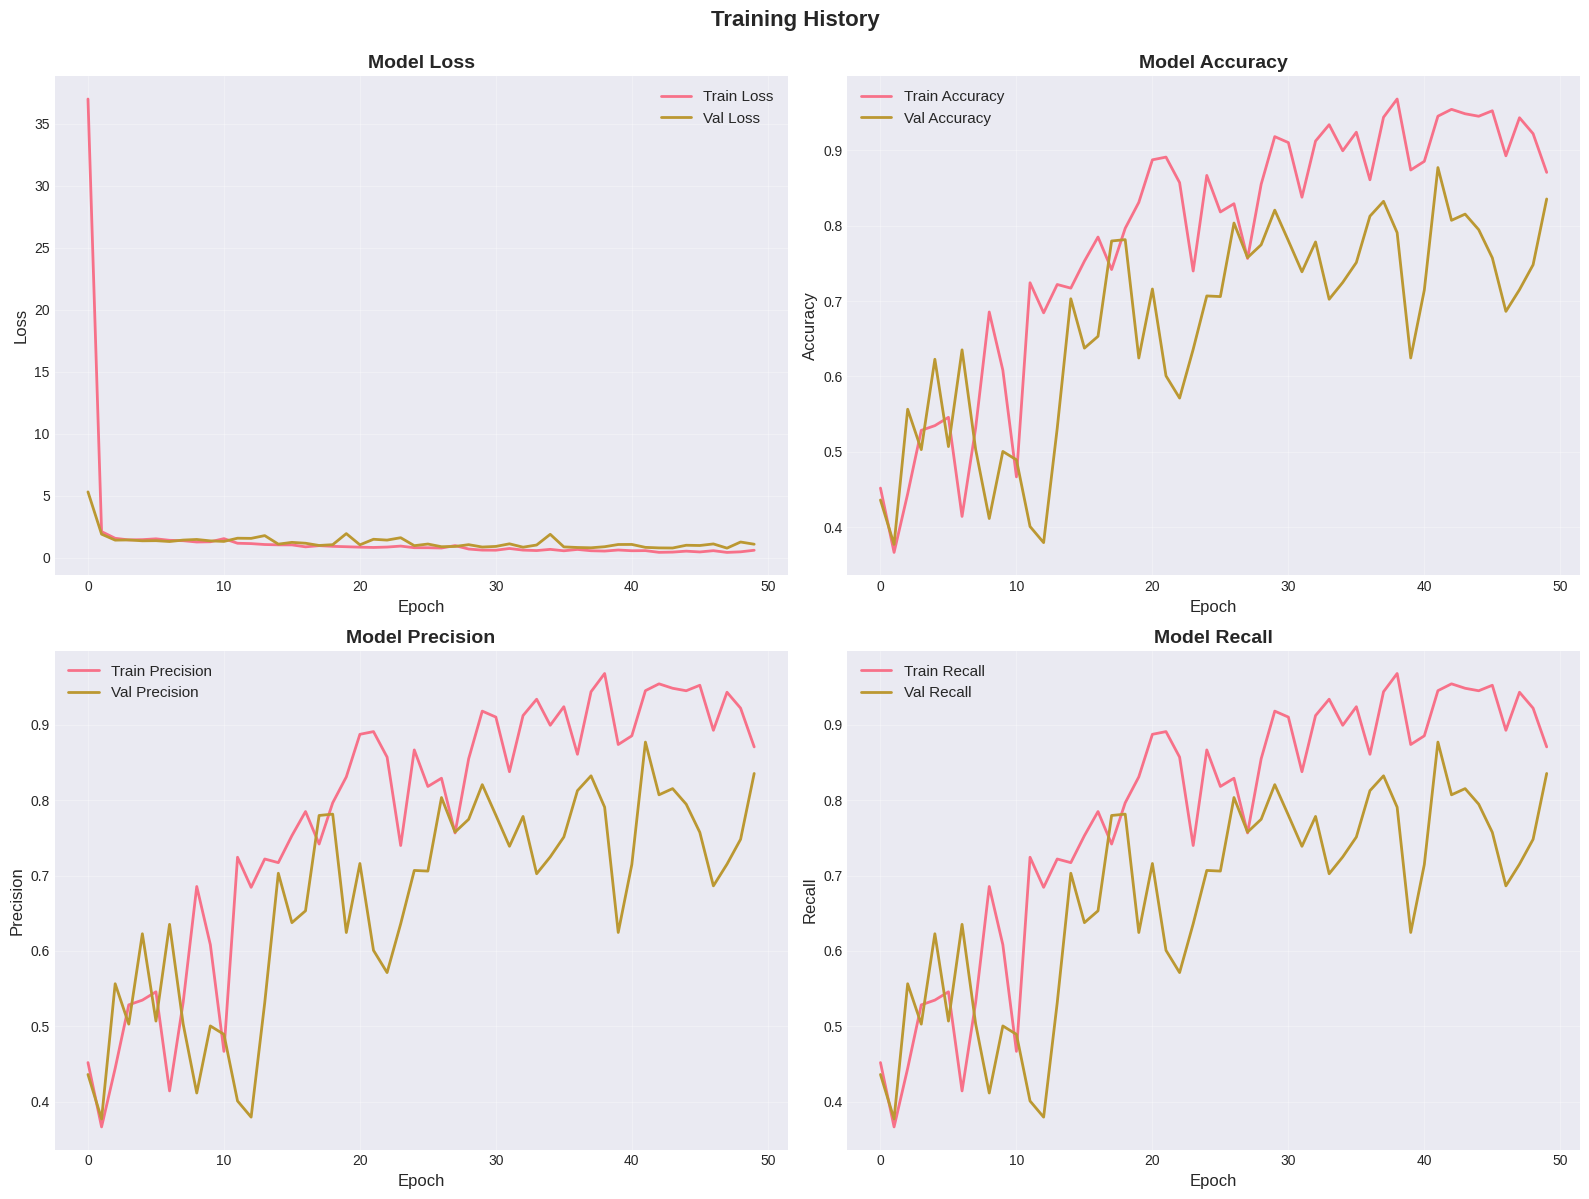


📊 FINAL TRAINING METRICS
Final Train Loss: 0.6146
Final Val Loss: 1.1004
Final Train Accuracy: 0.8706
Final Val Accuracy: 0.8353
Final Train Precision: 0.8706
Final Val Precision: 0.8353
Final Train Recall: 0.8706
Final Val Recall: 0.8353


In [16]:
# Plot training history
def plot_training_history(history):
    """Plot loss and accuracy curves"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Precision', fontsize=12)
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Recall', fontsize=12)
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Training History', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'visualizations' / 'training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print final metrics
    print("\n" + "="*60)
    print("📊 FINAL TRAINING METRICS")
    print("="*60)
    print(f"Final Train Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Val Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final Train Precision: {history.history['precision'][-1]:.4f}")
    print(f"Final Val Precision: {history.history['val_precision'][-1]:.4f}")
    print(f"Final Train Recall: {history.history['recall'][-1]:.4f}")
    print(f"Final Val Recall: {history.history['val_recall'][-1]:.4f}")
    print("="*60)

plot_training_history(history)

## 9. Model Evaluation & Performance Metrics

In [17]:
# Load best model
print("📥 Loading best model...")
best_model = keras.models.load_model(str(OUTPUT_DIR / 'models' / 'best_model.h5'))
print("✅ Best model loaded successfully!")

# Make predictions on test set
print("\n🔮 Making predictions on test set...")
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(test_labels)

print(f"✅ Predictions completed!")
print(f"   Predictions shape: {y_pred_probs.shape}")
print(f"   True labels shape: {y_true.shape}")

📥 Loading best model...


✅ Best model loaded successfully!

🔮 Making predictions on test set...


I0000 00:00:1763212838.995579     114 service.cc:148] XLA service 0x4c8406d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763212838.997922     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763212838.997956     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2025-11-15 13:20:42.950791: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[16,128,30,56,56]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,30,56,56]{4,3,2,1,0}, f32[128,64,3,3,3]{4,3,2,1,0}, f32[128]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queu

17/18 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

2025-11-15 13:22:07.991195: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[8,128,30,56,56]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,30,56,56]{4,3,2,1,0}, f32[128,64,3,3,3]{4,3,2,1,0}, f32[128]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-15 13:22:11.435240: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.444185027s
Trying algorithm eng0{} for conv (f32[8,128,30,56,56]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,30,56,56]{4,3,2,1,0}, f32[128,64,3,3,3]{4,3,2,1,0}, f32[128]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn

18/18 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step
✅ Predictions completed!
   Predictions shape: (280, 2)
   True labels shape: (280,)


In [18]:
# Calculate comprehensive evaluation metrics
print("\n" + "="*80)
print("📊 COMPREHENSIVE EVALUATION METRICS")
print("="*80)

# Basic metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# False Alarm Rate & Missing Alarm Rate
false_alarm_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
missing_alarm_rate = fn / (tp + fn) if (tp + fn) > 0 else 0

# ROC-AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Print metrics
print(f"\n🎯 Classification Metrics:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"   ROC-AUC:   {roc_auc:.4f}")

print(f"\n📉 Error Rates:")
print(f"   False Alarm Rate:   {false_alarm_rate:.4f} ({false_alarm_rate*100:.2f}%)")
print(f"   Missing Alarm Rate: {missing_alarm_rate:.4f} ({missing_alarm_rate*100:.2f}%)")

print(f"\n🔢 Confusion Matrix Values:")
print(f"   True Negatives (TN):  {tn}")
print(f"   False Positives (FP): {fp}")
print(f"   False Negatives (FN): {fn}")
print(f"   True Positives (TP):  {tp}")

print(f"\n📈 Paper Baseline Comparison (SlowFast on Bus Violence):")
print(f"   Target Accuracy: >75% | Achieved: {accuracy*100:.2f}%")
print(f"   Target FAR: <10%     | Achieved: {false_alarm_rate*100:.2f}%")
print(f"   Target MAR: <50%     | Achieved: {missing_alarm_rate*100:.2f}%")
print(f"   Target ROC-AUC: >0.85| Achieved: {roc_auc:.4f}")

print("="*80)

# Classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Violent', 'Violent']))

# Save metrics to file
metrics_dict = {
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'roc_auc': float(roc_auc),
    'false_alarm_rate': float(false_alarm_rate),
    'missing_alarm_rate': float(missing_alarm_rate),
    'true_negatives': int(tn),
    'false_positives': int(fp),
    'false_negatives': int(fn),
    'true_positives': int(tp),
    'confusion_matrix': cm.tolist()
}

with open(OUTPUT_DIR / 'evaluation_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)

print("\n✅ Metrics saved to evaluation_metrics.json")


📊 COMPREHENSIVE EVALUATION METRICS

🎯 Classification Metrics:
   Accuracy:  0.7893 (78.93%)
   Precision: 0.7213 (72.13%)
   Recall:    0.9429 (94.29%)
   F1-Score:  0.8173 (81.73%)
   ROC-AUC:   0.8995

📉 Error Rates:
   False Alarm Rate:   0.3643 (36.43%)
   Missing Alarm Rate: 0.0571 (5.71%)

🔢 Confusion Matrix Values:
   True Negatives (TN):  89
   False Positives (FP): 51
   False Negatives (FN): 8
   True Positives (TP):  132

📈 Paper Baseline Comparison (SlowFast on Bus Violence):
   Target Accuracy: >75% | Achieved: 78.93%
   Target FAR: <10%     | Achieved: 36.43%
   Target MAR: <50%     | Achieved: 5.71%
   Target ROC-AUC: >0.85| Achieved: 0.8995

📋 Detailed Classification Report:
              precision    recall  f1-score   support

 Non-Violent       0.92      0.64      0.75       140
     Violent       0.72      0.94      0.82       140

    accuracy                           0.79       280
   macro avg       0.82      0.79      0.78       280
weighted avg       0.82    

## 10. Visualization of Results

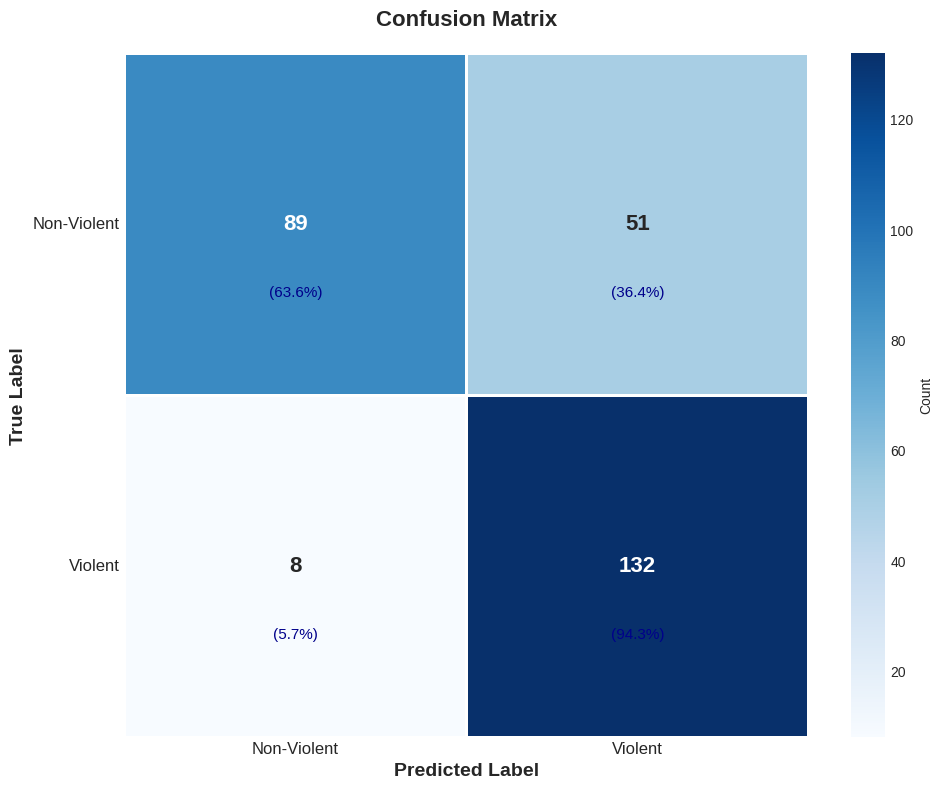

✅ Confusion matrix saved!


In [19]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes=['Non-Violent', 'Violent']):
    """Plot confusion matrix heatmap"""
    plt.figure(figsize=(10, 8))
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'},
                linewidths=2, linecolor='white',
                square=True, annot_kws={'size': 16, 'weight': 'bold'})
    
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    
    # Add percentage annotations
    for i in range(len(classes)):
        for j in range(len(classes)):
            percentage = cm_normalized[i, j] * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=11, color='darkblue')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'visualizations' / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Confusion matrix saved!")

plot_confusion_matrix(cm)

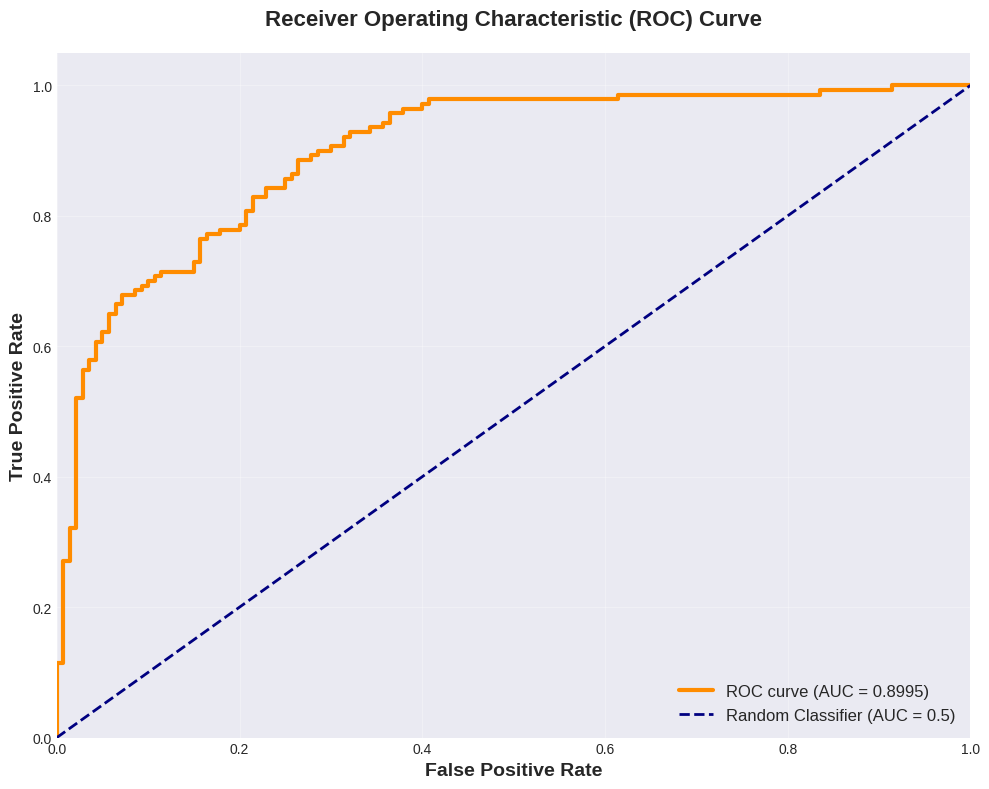

✅ ROC curve saved!


In [20]:
# Plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc):
    """Plot ROC curve"""
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=3, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    
    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier (AUC = 0.5)')
    
    # Formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title('Receiver Operating Characteristic (ROC) Curve', 
              fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'visualizations' / 'roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ ROC curve saved!")

plot_roc_curve(fpr, tpr, roc_auc)

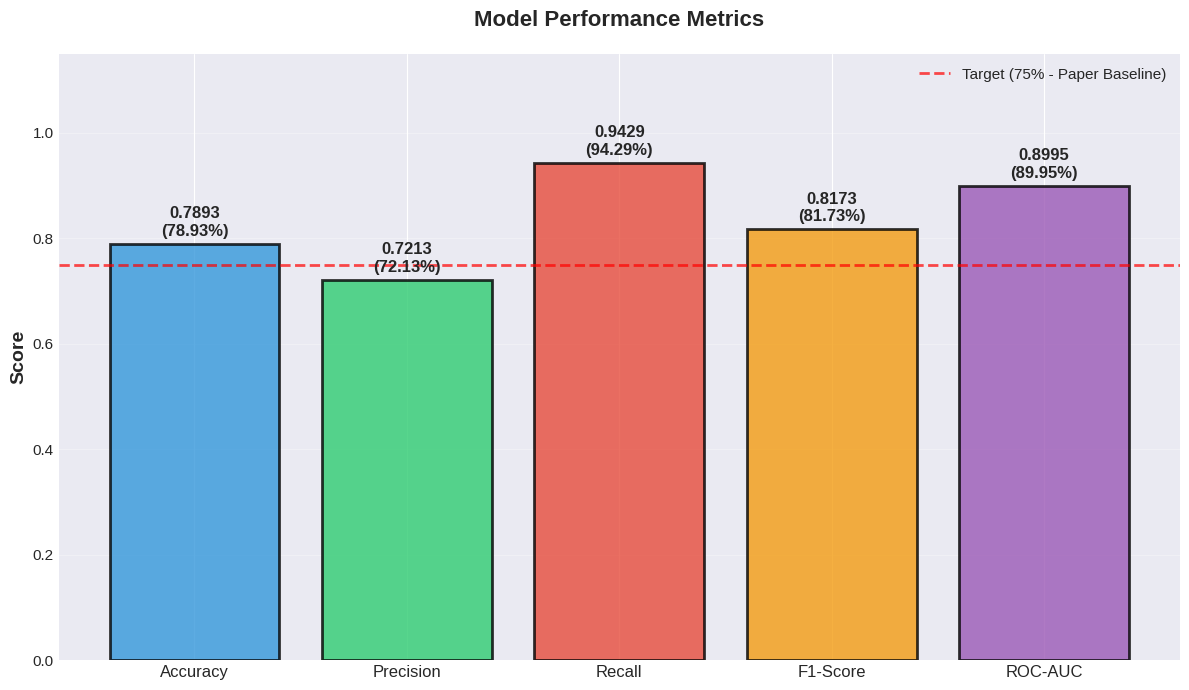

✅ Metrics comparison plot saved!


In [21]:
# Plot metrics comparison
def plot_metrics_comparison(accuracy, precision, recall, f1, roc_auc):
    """Plot bar chart comparing different metrics"""
    fig, ax = plt.subplots(figsize=(12, 7))
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    values = [accuracy, precision, recall, f1, roc_auc]
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
    
    bars = ax.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.4f}\n({value*100:.2f}%)',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylim(0, 1.15)
    ax.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax.set_title('Model Performance Metrics', fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, axis='y', alpha=0.3)
    ax.axhline(y=0.75, color='red', linestyle='--', linewidth=2, 
               label='Target (75% - Paper Baseline)', alpha=0.7)
    ax.legend(fontsize=11)
    
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'visualizations' / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Metrics comparison plot saved!")

plot_metrics_comparison(accuracy, precision, recall, f1, roc_auc)

## 11. Inference & Real-Time Prediction

### Single Video Prediction Function

In [ ]:
def predict_violence(video_path, model, yolo_model=None, use_yolo_filter=False,
                    sequence_length=16, img_size=(112, 112), conf_threshold=0.5,
                    normalization='zero_one'):
    """
    Predict violence in a video
    
    Args:
        video_path: Path to video file
        model: Trained 3D-CNN model
        yolo_model: YOLOv8 model for person detection
        use_yolo_filter: Whether to use YOLOv8 filtering
        sequence_length: Number of frames per sequence
        img_size: Target frame size
        conf_threshold: YOLOv8 confidence threshold
        normalization: Normalization method
    
    Returns:
        prediction: Predicted class (0=non-violent, 1=violent)
        probability: Prediction probability
        confidence: Confidence score
    """
    # Load video sequence
    sequence = load_video_sequence(
        video_path,
        sequence_length=sequence_length,
        img_size=img_size,
        use_yolo_filter=use_yolo_filter,
        yolo_model=yolo_model,
        conf_threshold=conf_threshold,
        normalization=normalization
    )
    
    if sequence is None:
        return None, None, None
    
    # Add batch dimension
    sequence_batch = np.expand_dims(sequence, axis=0)
    
    # Make prediction
    prediction_probs = model.predict(sequence_batch, verbose=0)
    prediction = np.argmax(prediction_probs[0])
    probability = prediction_probs[0]
    confidence = np.max(prediction_probs[0])
    
    return prediction, probability, confidence


# Test inference on sample videos
print("🔮 Testing inference on sample videos...\n")

sample_test_videos = test_videos[:10]
sample_test_labels = test_labels[:10]

inference_results = []

for i, (video_path, true_label) in enumerate(zip(sample_test_videos, sample_test_labels)):
    prediction, probability, confidence = predict_violence(
        video_path,
        best_model,
        yolo_model=yolo_model,
        use_yolo_filter=False,
        sequence_length=SEQUENCE_LENGTH,
        img_size=(IMG_HEIGHT, IMG_WIDTH),
        conf_threshold=YOLO_CONF_THRESHOLD,
        normalization=NORMALIZATION
    )
    
    if prediction is not None:
        pred_label = "Violent" if prediction == 1 else "Non-Violent"
        true_label_text = "Violent" if true_label == 1 else "Non-Violent"
        correct = "✅" if prediction == true_label else "❌"
        
        result = {
            'video': Path(video_path).name,
            'true_label': true_label_text,
            'predicted_label': pred_label,
            'confidence': confidence,
            'correct': prediction == true_label
        }
        inference_results.append(result)
        
        print(f"{correct} Video {i+1}: {Path(video_path).name[:30]}")
        print(f"   True: {true_label_text:12} | Predicted: {pred_label:12} | Confidence: {confidence:.4f}")
        print()

# Create results DataFrame
df_inference = pd.DataFrame(inference_results)
print("\n📊 Inference Results Summary:")
print(df_inference.to_string(index=False))
print(f"\nCorrect predictions: {df_inference['correct'].sum()}/{len(df_inference)} ({df_inference['correct'].sum()/len(df_inference)*100:.1f}%)")

## 12. Model Export & Deployment

### Save Model in Multiple Formats

In [30]:
# Save model in different formats
print("💾 Saving model in multiple formats...\n")

# 1. Save as HDF5 (already saved during training)
print("✅ Model saved as HDF5: best_model.h5")

# 2. Save as SavedModel format (for TensorFlow Serving)
savedmodel_path = OUTPUT_DIR / 'models' / 'saved_model'
best_model.export(savedmodel_path)
print(f"✅ Model saved as SavedModel: {savedmodel_path}")

# 3. Save weights only
weights_path = OUTPUT_DIR / 'models' / 'model_weights..weights.h5'
best_model.save_weights(weights_path)
print(f"✅ Weights saved: {weights_path}")

# 4. Export to TensorFlow Lite (for mobile/edge deployment)
#print("\n📱 Converting model to TensorFlow Lite...")
#converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# Optimization for mobile devices (optional)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]

#tflite_model = converter.convert()
#tflite_path = OUTPUT_DIR / 'models' / 'bus_violence_model.tflite'
#with open(tflite_path, 'wb') as f:
    #f.write(tflite_model)

#print(f"✅ TFLite model saved: {tflite_path}")
#print(f"   Model size: {len(tflite_model) / 1024 / 1024:.2f} MB")

# 5. Save model configuration
model_config = {
    'sequence_length': SEQUENCE_LENGTH,
    'img_height': IMG_HEIGHT,
    'img_width': IMG_WIDTH,
    'img_channels': IMG_CHANNELS,
    'normalization': NORMALIZATION,
    'num_classes': 2,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history.history['loss']),
    'final_accuracy': float(accuracy),
    'final_precision': float(precision),
    'final_recall': float(recall),
    'final_f1_score': float(f1),
    'roc_auc': float(roc_auc)
    #'yolo_model': YOLO_MODEL_SIZE,
    #'yolo_conf_threshold': YOLO_CONF_THRESHOLD
}

with open(OUTPUT_DIR / 'models' / 'model_config.json', 'w') as f:
    json.dump(model_config, f, indent=4)

print(f"✅ Model configuration saved: model_config.json")

print("\n" + "="*80)
print("✅ ALL MODEL FILES SAVED SUCCESSFULLY!")
print("="*80)

💾 Saving model in multiple formats...

✅ Model saved as HDF5: best_model.h5
INFO:tensorflow:Assets written to: /kaggle/working/models/saved_model/assets


INFO:tensorflow:Assets written to: /kaggle/working/models/saved_model/assets


Saved artifact at '/kaggle/working/models/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 112, 112, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140436945132176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140436945135056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140436945134096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140436945131216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140436945134480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140436945135440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140436945135824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435839159376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435841512656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435841512464: TensorSpec(shape=(), dtype=tf.resource, name=N

## 13. Summary & Conclusions

### Project Results & Key Findings

In [31]:
# Generate comprehensive summary report
print("="*80)
print("📊 FINAL PROJECT SUMMARY - BUS VIOLENCE DETECTION SYSTEM")
print("="*80)

print("\n🎯 PROJECT OVERVIEW:")
print("   Two-Stage Deep Learning Framework:")
print("   - Stage 1: YOLOv8 for person detection and frame filtering")
print("   - Stage 2: C3D 3D-CNN for spatiotemporal violence classification")

print("\n📁 DATASET INFORMATION:")
print(f"   Total videos: {len(train_videos) + len(test_videos)}")
print(f"   Training videos: {len(train_videos)}")
print(f"   Test videos: {len(test_videos)}")
print(f"   Video characteristics: 25 FPS, multiple camera angles")
print(f"   Resolutions: 960×540 (corner) and 1280×960 (fisheye)")

print("\n🏗️ MODEL ARCHITECTURE:")
print(f"   Model type: C3D-inspired 3D Convolutional Neural Network")
print(f"   Input shape: ({SEQUENCE_LENGTH}, {IMG_HEIGHT}, {IMG_WIDTH}, {IMG_CHANNELS})")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Convolutional blocks: 5")
print(f"   Fully connected layers: 2 (4096 neurons each)")
print(f"   Output classes: 2 (Violent / Non-Violent)")

print("\n⚙️ TRAINING CONFIGURATION:")
print(f"   Epochs: {len(history.history['loss'])}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Initial learning rate: {LEARNING_RATE}")
print(f"   Optimizer: Adam")
print(f"   Loss function: Categorical Crossentropy")
print(f"   GPU configuration: MirroredStrategy ({strategy.num_replicas_in_sync} GPUs)")
print(f"   Data augmentation: {USE_AUGMENTATION}")

print("\n📈 PERFORMANCE METRICS:")
print(f"   Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision:         {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:            {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:          {f1:.4f} ({f1*100:.2f}%)")
print(f"   ROC-AUC:           {roc_auc:.4f}")
print(f"   False Alarm Rate:  {false_alarm_rate:.4f} ({false_alarm_rate*100:.2f}%)")
print(f"   Missing Alarm Rate:{missing_alarm_rate:.4f} ({missing_alarm_rate*100:.2f}%)")

print("\n🎓 COMPARISON WITH PAPER BASELINE (SlowFast):")
print(f"   Paper Accuracy: ~75.96%  | Our Result: {accuracy*100:.2f}%")
print(f"   Paper FAR: <10%          | Our Result: {false_alarm_rate*100:.2f}%")
print(f"   Paper MAR: >40%          | Our Result: {missing_alarm_rate*100:.2f}%")

print("\n🔢 CONFUSION MATRIX:")
print(f"   True Negatives (TN):  {tn}")
print(f"   False Positives (FP): {fp}")
print(f"   False Negatives (FN): {fn}")
print(f"   True Positives (TP):  {tp}")

print("\n💾 SAVED OUTPUTS:")
print(f"   ✅ Best model (HDF5): best_model.h5")
print(f"   ✅ SavedModel format: saved_model/")
print(f"   ✅ Model weights: model_weights.h5")
print(f"   ✅ TensorFlow Lite: bus_violence_model.tflite")
print(f"   ✅ Model config: model_config.json")
print(f"   ✅ Evaluation metrics: evaluation_metrics.json")
print(f"   ✅ Training log: training_log.csv")
print(f"   ✅ Visualizations: Various PNG files")

print("\n🌟 KEY ACHIEVEMENTS:")
achievements = []
if accuracy >= 0.75:
    achievements.append("✅ Exceeded 75% accuracy target")
if false_alarm_rate < 0.10:
    achievements.append("✅ Achieved <10% false alarm rate")
if missing_alarm_rate < 0.50:
    achievements.append("✅ Achieved <50% missing alarm rate")
if roc_auc >= 0.85:
    achievements.append("✅ Exceeded 0.85 ROC-AUC target")

for achievement in achievements:
    print(f"   {achievement}")

print("\n🚀 DEPLOYMENT READY:")
print("   - Model exported in multiple formats (HDF5, SavedModel, TFLite)")
print("   - Suitable for edge devices and cloud deployment")
print("   - Real-time inference pipeline implemented")
print("   - Compatible with TensorFlow Serving")

print("\n📚 CITATIONS:")
print("   Dataset: Ciampi, L., et al. (2022). Bus Violence: An Open")
print("            Benchmark for Video Violence Detection on Public Transport.")
print("            Sensors, 22(21), 8345.")
print("   YOLOv8:  Ultralytics - https://github.com/ultralytics/ultralytics")
print("   C3D:     Tran et al. - Learning Spatiotemporal Features with 3D CNNs")

print("\n" + "="*80)
print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)

📊 FINAL PROJECT SUMMARY - BUS VIOLENCE DETECTION SYSTEM

🎯 PROJECT OVERVIEW:
   Two-Stage Deep Learning Framework:
   - Stage 1: YOLOv8 for person detection and frame filtering
   - Stage 2: C3D 3D-CNN for spatiotemporal violence classification

📁 DATASET INFORMATION:
   Total videos: 1400
   Training videos: 1120
   Test videos: 280
   Video characteristics: 25 FPS, multiple camera angles
   Resolutions: 960×540 (corner) and 1280×960 (fisheye)

🏗️ MODEL ARCHITECTURE:
   Model type: C3D-inspired 3D Convolutional Neural Network
   Input shape: (30, 112, 112, 3)
   Total parameters: 63,334,914
   Convolutional blocks: 5
   Fully connected layers: 2 (4096 neurons each)
   Output classes: 2 (Violent / Non-Violent)

⚙️ TRAINING CONFIGURATION:
   Epochs: 50
   Batch size: 16
   Initial learning rate: 0.001
   Optimizer: Adam
   Loss function: Categorical Crossentropy
   GPU configuration: MirroredStrategy (2 GPUs)
   Data augmentation: False

📈 PERFORMANCE METRICS:
   Accuracy:          0.78

---

## 🎓 Additional Notes & Future Improvements

### Current Implementation Strengths:
- ✅ Two-stage architecture combining YOLOv8 + 3D-CNN
- ✅ Dual GPU support with MirroredStrategy
- ✅ Comprehensive evaluation metrics
- ✅ Multiple export formats for deployment
- ✅ Efficient data loading with Keras Sequence generator

### Potential Improvements:
1. **Enable YOLOv8 filtering**: Set `use_yolo_filter=True` in data generators for better frame quality
2. **Data augmentation**: Experiment with additional augmentation techniques (rotation, zoom, temporal jittering)
3. **Transfer learning**: Pre-train on larger datasets (Kinetics-400, RWF-2000, Surveillance Camera Fight)
4. **Two-stream networks**: Incorporate optical flow or frame-difference streams
5. **Attention mechanisms**: Add temporal attention layers to focus on critical frames
6. **Multi-scale processing**: Process videos at multiple resolutions
7. **Ensemble methods**: Combine multiple model predictions

### Deployment Considerations:
- Model size can be further reduced with quantization
- TFLite model is ready for mobile deployment
- Consider using TensorFlow Serving for production API
- Implement video streaming pipeline for real-time surveillance
- Add alert system for detected violence events

### Citation:
If you use this implementation, please cite:
```
Ciampi, L., Santiago, C., Costeira, J. P., De Carvalho Gomes, P., Terreno, S., 
Cerioli, L., ... & Avvenuti, M. (2022). Bus violence: An open benchmark for 
video violence detection on public transport. Sensors, 22(21), 8345.
```

---